## Methods notebook

point of this notebook is to take the ideas from the working notebook to make some methods

In [1]:
#############################Import Block#############################
import matplotlib.pyplot as plt #plotting
from pathlib import Path #paths
import glob #glob files
import os #system commands in case we need it
import numpy as np #handling numbers if needed
import pandas as pd #handling data in dataframes
import pytraj as pt #cpptraj, but python
from pymol import cmd,stored #pymol commands and stuffs
import scipy.stats as stats #for stats.entropy
import seaborn as sns #heatmap, plotting functions
from tqdm import tqdm #progress bars
from sklearn.preprocessing import minmax_scale #scale statistics to (0,1)
from sklearn import preprocessing as p #scale 2d stats to a normalized range [0,1]
min_max_scaler = p.MinMaxScaler() #initialize 2d scaler for later
#############################Import Block#############################

In [2]:
class proteinAnalysis:
    '''
    Class definition for protein and ligand analysis
    '''
    time = []
    resnames = []
    resids = []
    ligresn = []
    ligresi = []
    bb_rmsd = []
    lig_rmsd = []
    ha_rmsd = []
    sc_rmsd = []
    ca_rmsd = []
    byres_ca_rmsd = []
    byres_bb_rmsd = []
    byres_sc_rmsd = []
    byres_ha_rmsd = []
    byres_ca_rmsd_avg = []
    byres_bb_rmsd_avg = []
    byres_sc_rmsd_avg = []
    byres_ha_rmsd_avg = []
    byres_ca_rmsd_std = []
    byres_bb_rmsd_std = []
    byres_sc_rmsd_std = []
    byres_ha_rmsd_std = []
    byres_ca_rmsd_std1 = []
    byres_bb_rmsd_std1 = []
    byres_sc_rmsd_std1 = []
    byres_ha_rmsd_std1 = []
    byres_ca_rmsd_std2 = []
    byres_bb_rmsd_std2 = []
    byres_sc_rmsd_std2 = []
    byres_ha_rmsd_std2 = []
    byres_bb_dih = [] #backbone
    byres_sc_dih = [] #sidechain
    byres_bb_dih_avg = []
    byres_bb_dih_std = []
    byres_bb_dih_std1 = []
    byres_bb_dih_std2 = []
    byres_sc_dih_avg = []
    byres_sc_dih_std = []
    byres_sc_dih_std1 = []
    byres_sc_dih_std2 = []
    byres_bb_pos = [] # backbone byresidue position (center of geometry)
    byres_sc_pos = [] # sidechain byresidue position (center of geometry)
    byres_bb_avgpos = [] #backbone byresidue average position (center of geometry)
    byres_sc_avgpos = [] # sidechain byresidue average position (center of geometry)
    byres_bb_dev = [] #backbone byresidue position deviation from average
    byres_sc_dev = [] #sidechain byresidue position deviation from average
    byres_bb_corrmatrix = [] #backbone correlation matrix
    byres_sc_corrmatrix = [] #sidechain correlation matrix
    byres_bb_variation = [] #variation in byresidue deviations from mean, backbone
    byres_sc_variation = [] #variation in byresidue deviations from mean, sidechain
    trajectory = None
    ref = None
    out_dir = None
    timestep = 10
    def __init__(self, refPdb, outDir, timestep = 10):
        '''
        initialization of class should require a reference pdb. 
        This should be the xtal or first frame
        
        refPdb = reference pdb, xtal or first frame
        timestep = time step of frames provided, default to 10 ps
        '''
        stored.list = []
        iresnames = []
        iresids = []
        iligresn = []
        iligresi = []
        cmd.reinitialize()
        cmd.load(refPdb)
        cmd.select('protein-residues', 'polymer.protein and name CA')
        cmd.iterate('protein-residues', 'stored.list.append((resi, resn))')
        for k,tup in enumerate(stored.list):
            iresnames.append(tup[1])
            iresids.append(tup[0])
        stored.list = []
        unwanted_organics = ['GOL','EDO', 'ACE', 'NME'] #add to the list as we go
        cmd.select('ligand', 'organic')
        cmd.iterate('ligand', 'stored.list.append((resi, resn))')
        for k,tup in enumerate(stored.list):
            if tup[1] not in unwanted_organics:
                iligresn.append(tup[1])
                iligresi.append(tup[0])
        self.resnames = iresnames
        self.resids = iresids
        self.ligresn = iligresn
        self.ligresi = iligresi
        self.ref = pt.load(refPdb)
        self.out_dir = outDir
        self.timestep = timestep
    def loadTrajectory(self, traj, top, align=None, skip_interval=None):
        '''
        Method to load trajectory and align as needed, maybe should be in init
        
        align is a string that defines by how the structure should be aligned

        skip_interval is the stride over the trajectory if provided. If none skip, else stride by that number
        
        eg '@CA' for alpha carbons
        '''
        if skip_interval == None:
            self.trajectory = pt.load(traj, top)
        else:
            self.trajectory = pt.load(traj, top, stride=skip_interval)
        if align is not None:
            self.trajectory = pt.align(self.trajectory, align, self.ref)

    def plotProteinRMSD(self):
        '''
        Method to generate rmsd plots for whole protein
        '''
        df = pd.DataFrame()
        ca_rms = pt.rmsd_nofit(self.trajectory, mask='@CA')
        bb_rms = pt.rmsd_nofit(self.trajectory, mask='!:HOH,WAT&@CA,C,N,O')
        ha_rms = pt.rmsd_nofit(self.trajectory, mask='!:HOH,WAT&!@H=')
        sc_rms = pt.rmsd_nofit(self.trajectory, mask='!:HOH,WAT&!@CA,C,N,O')
        for k,rms in enumerate(ca_rms):
            self.time.append(int(k * self.timestep))
            self.ca_rmsd.append(rms)
            self.ha_rmsd.append(ha_rms[k])
            self.bb_rmsd.append(bb_rms[k])
            self.sc_rmsd.append(sc_rms[k])
        f1 = plt.figure()
        plt.plot(self.time, self.ca_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('CA rmsd (Å)')
        plt.savefig(str(self.out_dir / 'protein_CA_rmsd.png'))
        f2 = plt.figure()
        plt.plot(self.time, self.bb_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('BB rmsd (Å)')
        plt.savefig(str(self.out_dir / 'protein_BB_rmsd.png'))
        f3 = plt.figure()
        plt.plot(self.time, self.sc_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('SC rmsd (Å)')
        plt.savefig(str(self.out_dir / 'protein_SC_rmsd.png'))
        f4 = plt.figure()
        plt.plot(self.time, self.ha_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('HA rmsd (Å)')
        plt.savefig(str(self.out_dir / 'protein_HA_rmsd.png'))
        df['simtime'] = self.time
        df['CA RMSD (Å)'] = self.ca_rmsd
        df['BB RMSD (Å)'] = self.bb_rmsd
        df['SC RMSD (Å)'] = self.sc_rmsd
        df['HA RMSD (Å)'] = self.ha_rmsd
        df.to_csv(str(self.out_dir / 'proteinRMSD.csv'), index=False)
        del df
        return
        
    def plotLigandRMSD(self):
        '''
        Method to generate ligand rmsd (provided there is a ligand)
        '''
        if len(self.ligresn) == 0:
            print('No ligand in system check initialization')
            return
        df = pd.DataFrame()
        lig_rms = pt.rmsd_nofit(self.trajectory, mask=f':{self.ligresi[0]}&!@H=')
        self.lig_rmsd = np.array(lig_rms)
        f1 = plt.figure()
        plt.plot(self.time, self.lig_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('ligand rmsd (Å)')
        plt.savefig(str(self.out_dir / 'ligand_rmsd.png'))
        df['simtime'] = self.time
        df['ligand RMSD (Å)'] = self.lig_rmsd
        df.to_csv(str(self.out_dir / 'ligandRMSD.csv'), index=False)
        del df
        return
    
    def plotByResRMSD(self):
        '''
        Method to plot by residue rmsds
        '''
        for k,res in enumerate(self.resids):
            ca = pt.rmsd_nofit(self.trajectory, mask=f':{res}&@CA')
            bb = pt.rmsd_nofit(self.trajectory, mask=f':{res}&@CA,C,N,O&!:HOH,WAT')
            sc = pt.rmsd_nofit(self.trajectory, mask=f':{res}&!@CA,C,N,O&!:HOH,WAT')
            ha = pt.rmsd_nofit(self.trajectory, mask=f':{res}&!:HOH,WAT&!@H=')
            ca_avg = np.mean(ca)
            bb_avg = np.mean(bb)
            sc_avg = np.mean(sc)
            ha_avg = np.mean(ha)
            ca_std = np.std(ca)
            bb_std = np.std(bb)
            sc_std = np.std(sc)
            ha_std = np.std(ha)
            ca_std1 = np.std(ca[:int(len(ca)/2)])
            bb_std1 = np.std(bb[:int(len(ca)/2)])
            sc_std1 = np.std(sc[:int(len(ca)/2)])
            ha_std1 = np.std(ha[:int(len(ca)/2)])
            ca_std2 = np.std(ca[int(len(ca)/2):])
            bb_std2 = np.std(bb[int(len(ca)/2):])
            sc_std2 = np.std(sc[int(len(ca)/2):])
            ha_std2 = np.std(ha[int(len(ca)/2):])
            self.byres_ca_rmsd.append(ca)
            self.byres_bb_rmsd.append(bb)
            self.byres_sc_rmsd.append(sc)
            self.byres_ha_rmsd.append(ha)
            self.byres_ca_rmsd_avg.append(ca_avg)
            self.byres_ca_rmsd_std.append(ca_std)
            self.byres_ca_rmsd_std1.append(ca_std1)
            self.byres_ca_rmsd_std2.append(ca_std2)
            self.byres_bb_rmsd_avg.append(bb_avg)
            self.byres_bb_rmsd_std.append(bb_std)
            self.byres_bb_rmsd_std1.append(bb_std1)
            self.byres_bb_rmsd_std2.append(bb_std2)
            self.byres_sc_rmsd_avg.append(sc_avg)
            self.byres_sc_rmsd_std.append(sc_std)
            self.byres_sc_rmsd_std1.append(sc_std1)
            self.byres_sc_rmsd_std2.append(sc_std2)
            self.byres_ha_rmsd_avg.append(ha_avg)
            self.byres_ha_rmsd_std.append(ha_std)
            self.byres_ha_rmsd_std1.append(ha_std1)
            self.byres_ha_rmsd_std2.append(ha_std2)
        f1 = plt.figure()
        plt.plot(self.resids, self.byres_ca_rmsd_avg, 'b-')
        plt.errorbar(self.resids, self.byres_ca_rmsd_avg, self.byres_ca_rmsd_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean CA RMSD')
        plt.savefig(str(self.out_dir / 'byres_mean_ca_rmsd.png'))
        f2 = plt.figure()
        plt.plot(self.resids, self.byres_bb_rmsd_avg, 'b-')
        plt.errorbar(self.resids, self.byres_bb_rmsd_avg, self.byres_bb_rmsd_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean BB RMSD')
        plt.savefig(str(self.out_dir / 'byres_mean_bb_rmsd.png'))
        f3 = plt.figure()
        plt.plot(self.resids, self.byres_sc_rmsd_avg, 'b-')
        plt.errorbar(self.resids, self.byres_sc_rmsd_avg, self.byres_sc_rmsd_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean SC RMSD')
        plt.savefig(str(self.out_dir / 'byres_mean_sc_rmsd.png'))
        f4 = plt.figure()
        plt.plot(self.resids, self.byres_ha_rmsd_avg, 'b-')
        plt.errorbar(self.resids, self.byres_ha_rmsd_avg, self.byres_ha_rmsd_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean HA RMSD')
        plt.savefig(str(self.out_dir / 'byres_mean_ha_rmsd.png'))
        df = pd.DataFrame()
        df['resid'] = self.resids
        df['resname'] = self.resnames
        df['Avg CA RMSD'] = self.byres_ca_rmsd_avg
        df['Std CA RMSD'] = self.byres_ca_rmsd_std
        df['First half Std CA RMSD'] = self.byres_ca_rmsd_std1
        df['Second half Std CA RMSD'] = self.byres_ca_rmsd_std2
        df['Avg BB RMSD'] = self.byres_bb_rmsd_avg
        df['Std BB RMSD'] = self.byres_bb_rmsd_std
        df['First half Std BB RMSD'] = self.byres_bb_rmsd_std1
        df['Second half Std BB RMSD'] = self.byres_bb_rmsd_std2
        df['Avg SC RMSD'] = self.byres_sc_rmsd_avg
        df['Std SC RMSD'] = self.byres_sc_rmsd_std
        df['First half Std SC RMSD'] = self.byres_sc_rmsd_std1
        df['Second half Std SC RMSD'] = self.byres_sc_rmsd_std2
        df['Avg HA RMSD'] = self.byres_ha_rmsd_avg
        df['Std HA RMSD'] = self.byres_ha_rmsd_std
        df['First half Std HA RMSD'] = self.byres_ha_rmsd_std1
        df['Second half Std HA RMSD'] = self.byres_ha_rmsd_std2
        df.to_csv(str(self.out_dir / 'Byres_rsmd.csv'), index=False)
        del df
        return
        
    def plotByResDih(self):
        '''
        Method to plot by residue dihedrals
        '''
        res_CG = ['ARG','PHE','LEU','LYS','ASN','GLN','TRP','GLU','ASP','HIS','HIE','HID','HIP','TYR']
        res_CG1 = ['VAL','ILE']
        res_OG1 = ['THR']
        res_OG = ['SER']
        res_SG = ['CYS']
        res_SD = ['MET']
        res_HB1 = ['ALA']
        for k,res in enumerate(self.resids):
            bb = pt.dihedral(self.trajectory, f':{res}&@N :{res}&@CA :{res}&@C :{res}&!:HOH,WAT&@O')
            if self.resnames[k] == 'GLY' or self.resnames[k] == 'PRO':
                sc = []
                for j,dih in enumerate(bb):
                    sc.append(0)
            else:
                if self.resnames[k] in res_CG:
                    atom = 'CG'
                elif self.resnames[k] in res_CG1:
                    atom = 'CG1'
                elif self.resnames[k] in res_OG1:
                    atom = 'OG1'
                elif self.resnames[k] in res_OG:
                    atom = 'OG'
                elif self.resnames[k] in res_SG:
                    atom = 'SG'
                elif self.resnames[k] in res_SD:
                    atom = 'SD'
                elif self.resnames[k] in res_HB1:
                    atom = 'HB1'
                sc = pt.dihedral(self.trajectory, f':{res}&@N :{res}&@CA :{res}&@CB :{res}&@{atom}')
            bb_avg = np.mean(bb)
            bb_std = np.std(bb)
            bb_std1 = np.std(bb[:int((len(bb)/2))])
            bb_std2 = np.std(bb[int((len(bb)/2)):])
            sc_avg = np.mean(sc)
            sc_std = np.std(sc)
            sc_std1 = np.std(sc[:int((len(sc)/2))])
            sc_std2 = np.std(sc[int((len(sc)/2)):])
            self.byres_bb_dih_avg.append(bb_avg)
            self.byres_bb_dih_std.append(bb_std)
            self.byres_bb_dih_std1.append(bb_std1)
            self.byres_bb_dih_std2.append(bb_std2)
            self.byres_sc_dih_avg.append(sc_avg)
            self.byres_sc_dih_std.append(sc_std)
            self.byres_sc_dih_std1.append(sc_std1)
            self.byres_sc_dih_std2.append(sc_std2)
        f1 = plt.figure()
        plt.plot(self.resids, self.byres_bb_dih_avg, 'b-')
        plt.errorbar(self.resids, self.byres_bb_dih_avg, self.byres_bb_dih_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean BB Dihedral')
        plt.savefig(str(self.out_dir / 'mean_bb_dihedral.png'))
        f2 = plt.figure()
        plt.plot(self.resids, self.byres_sc_dih_avg, 'b-')
        plt.errorbar(self.resids, self.byres_sc_dih_avg, self.byres_sc_dih_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean SC Dihedral')
        plt.savefig(str(self.out_dir / 'mean_sc_dihedral.png'))
        df = pd.DataFrame()
        df['resid'] = self.resids
        df['resname'] = self.resnames
        df['Avg BB dihedral'] = self.byres_bb_dih_avg
        df['Std BB dihedral'] = self.byres_bb_dih_std
        df['First half std BB dihedral'] = self.byres_bb_dih_std1
        df['Second half std BB dihedral'] = self.byres_bb_dih_std2
        df['Avg SC dihedral'] = self.byres_sc_dih_avg
        df['Std SC dihedral'] = self.byres_sc_dih_std
        df['First half std SC dihedral'] = self.byres_sc_dih_std1
        df['Second half std SC dihedral'] = self.byres_sc_dih_std2
        df.to_csv(str(self.out_dir / 'byres_dihedrals.csv'), index=False)
        del df
        return

    def correlatedMotions(self):
        '''
            Function to call to calculate the correlated motions matrix of each residue

            This will be a matrix that contains the information:
                C_ij = < dr_i * dr_j > / (<dr_i ^2 < dr_j^2 >) ^ (1/2)

                Where dr_i is the change in position for the ith element relative to its mean sampled position:
                dr_i = <r_i> - r_i

                all the values in the final C_ij calculation should be averages


                So firstly we need mean positions...

                We will want mean positions of backbones and mean positions of sidechains separately handled

                Should output both a summary of each residues deviations and also the correlation matrix                
        '''

        for k,res in enumerate(self.resids):
            bb = pt.center_of_geometry(self.trajectory, mask=f':{res}&@CA,C,N,O&!:HOH,WAT')
            sc = pt.center_of_geometry(self.trajectory, mask=f':{res}&!@CA,C,N,O&!:HOH,WAT')
            bb_avg = np.array(bb)
            sc_avg = np.array(sc)
            self.byres_bb_pos.append(bb_avg)
            self.byres_sc_pos.append(sc_avg)
        self.byres_bb_pos = np.array(self.byres_bb_pos)
        self.byres_sc_pos = np.array(self.byres_sc_pos)
        for k,res in enumerate(self.byres_bb_pos): # loop through each residue
            bb_x_mean = np.mean(res[:][0])
            bb_y_mean = np.mean(res[:][1])
            bb_z_mean = np.mean(res[:][2])
            sc_x_mean = np.mean(self.byres_sc_pos[:][0])
            sc_y_mean = np.mean(self.byres_sc_pos[:][1])
            sc_z_mean = np.mean(self.byres_sc_pos[:][2])
            temp_bb = np.array([bb_x_mean, bb_y_mean, bb_z_mean])
            temp_sc = np.array([sc_x_mean, sc_y_mean, sc_z_mean])
            self.byres_bb_avgpos.append(temp_bb)
            self.byres_sc_avgpos.append(temp_sc)
        self.byres_bb_avgpos = np.array(self.byres_bb_avgpos)
        self.byres_sc_avgpos = np.array(self.byres_sc_avgpos)
        
        #byres_bb_dev
        for k,res in enumerate(self.byres_bb_pos): #loop through each residue
            temp_bb = [] #storage for deviation backbone
            temp_sc = [] #storage for deviation sidechains
            for j,frame in enumerate(res): #loop through each frame
                diff_bb = []
                diff_sc = []
                diff_bb.append(self.byres_bb_avgpos[k][0] - frame[0])
                diff_bb.append(self.byres_bb_avgpos[k][1] - frame[1])
                diff_bb.append(self.byres_bb_avgpos[k][2] - frame[2])
                diff_sc.append(self.byres_sc_avgpos[k][0] - self.byres_sc_pos[k][j][0])
                diff_sc.append(self.byres_sc_avgpos[k][1] - self.byres_sc_pos[k][j][1])
                diff_sc.append(self.byres_sc_avgpos[k][2] - self.byres_sc_pos[k][j][2])
                diff_bb = np.array(diff_bb)
                diff_sc = np.array(diff_sc)
                temp_bb.append(diff_bb)
                temp_sc.append(diff_sc)
            temp_bb = np.array(temp_bb)
            temp_sc = np.array(temp_sc)
            self.byres_bb_dev.append(temp_bb)
            self.byres_sc_dev.append(temp_sc)
        self.byres_bb_dev = np.array(self.byres_bb_dev)
        self.byres_sc_dev = np.array(self.byres_sc_dev)
        #################################Memory clear block#################################
        ##at this point we no longer need the positions...we should delete them, we need the memory
        self.byres_bb_pos = np.zeros(1)
        self.byres_sc_pos = np.zeros(1)
        self.byres_bb_avgpos = np.zeros(1)
        self.byres_sc_avgpos = np.zeros(1)
        #################################Memory clear block#################################
        ## mean(dr_i * dr_j) / sqrt(mean(dr_i^2)*mean(dr_j^2))
        mean_bb_dri2 = []
        #mean_bb_dri = []
        mean_sc_dri2 = []
        #mean_sc_dri = []
        for k,res in enumerate(self.byres_bb_dev):
            temp_dri2 = []
            temp_dri2.append(np.mean(res[:][0])*np.mean(res[:][0]))
            temp_dri2.append(np.mean(res[:][1])*np.mean(res[:][1]))
            temp_dri2.append(np.mean(res[:][2])*np.mean(res[:][2]))
            mean_bb_dri2.append(temp_dri2)
            # temp_dri2 = []
            # temp_dri2.append(np.mean(res[:][0]))
            # temp_dri2.append(np.mean(res[:][1]))
            # temp_dri2.append(np.mean(res[:][2]))
            # mean_bb_dri.append(temp_dri2)
            temp_dri2 = []
            temp_dri2.append(np.mean(self.byres_sc_dev[k][:][0])*np.mean(self.byres_sc_dev[k][:][0]))
            temp_dri2.append(np.mean(self.byres_sc_dev[k][:][1])*np.mean(self.byres_sc_dev[k][:][1]))
            temp_dri2.append(np.mean(self.byres_sc_dev[k][:][2])*np.mean(self.byres_sc_dev[k][:][2]))
            mean_sc_dri2.append(temp_dri2)
            # temp_dri2 = []
            # temp_dri2.append(np.mean(self.byres_sc_dev[k][:][0]))
            # temp_dri2.append(np.mean(self.byres_sc_dev[k][:][1]))
            # temp_dri2.append(np.mean(self.byres_sc_dev[k][:][2]))
            # mean_sc_dri.append(temp_dri2)
        mean_bb_dri2 = np.array(mean_bb_dri2)
        mean_sc_dri2 = np.array(mean_sc_dri2)
        #define these now to make sure we have the memory :D
        self.byres_bb_corrmatrix = np.zeros([int(self.byres_bb_dev.shape[0]), int(self.byres_bb_dev.shape[0])])
        self.byres_sc_corrmatrix = np.zeros([int(self.byres_sc_dev.shape[0]), int(self.byres_sc_dev.shape[0])])
        for k in tqdm(range(self.byres_bb_dev.shape[0])):
            for j,res2 in enumerate(self.byres_bb_dev):
                if k==j:
                    continue
                bb_frame = []
                sc_frame = []
                for l, frame in enumerate(self.byres_bb_dev[0]):
                    bb_frame.append(np.dot(self.byres_bb_dev[k][l], self.byres_bb_dev[j][l]))
                    sc_frame.append(np.dot(self.byres_sc_dev[k][l], self.byres_sc_dev[j][l]))
                self.byres_bb_corrmatrix[k][j] = np.absolute(np.mean(bb_frame) / (np.sqrt(np.dot(mean_bb_dri2[k], mean_bb_dri2[j]))))
                self.byres_sc_corrmatrix[k][j] = np.absolute(np.mean(sc_frame) / (np.sqrt(np.dot(mean_sc_dri2[k], mean_sc_dri2[j]))))
        self.byres_bb_variation = np.zeros(self.byres_bb_dev.shape[0])
        self.byres_sc_variation = np.zeros(self.byres_sc_dev.shape[0])
        for k,var in enumerate(self.byres_bb_variation):
            self.byres_bb_variation[k] = np.std(self.byres_bb_dev[k])
            self.byres_sc_variation[k] = np.std(self.byres_sc_dev[k])
        self.byres_bb_dev = np.zeros(1)
        self.byres_sc_dev = np.zeros(1)
        del mean_bb_dri2
        del mean_sc_dri2
        #rescale variation and corrmatrices to 0,1 -- this way the visualizations are more intuitive
        self.byres_bb_corrmatrix = min_max_scaler.fit_transform(self.byres_bb_corrmatrix)
        self.byres_sc_corrmatrix = min_max_scaler.fit_transform(self.byres_sc_corrmatrix)
        variation = minmax_scale(pA.byres_bb_variation, feature_range=(0,1))
        self.byres_bb_variation = minmax_scale(self.byres_bb_variation, feature_range=(0,1))
        self.byres_sc_variation = minmax_scale(self.byres_sc_variation, feature_range=(0,1))
        f1 = plt.figure()
        ax = sns.heatmap(self.byres_bb_corrmatrix, linewidth=0.5, cmap='BuPu')
        plt.xlabel('residue number')
        plt.ylabel('residue number')
        plt.title('Backbone correlated motion heatmap')
        plt.savefig(str(self.out_dir / 'bb_corrMatrix.png'))
        f2 = plt.figure()
        ax = sns.heatmap(self.byres_sc_corrmatrix, linewidth=0.5, cmap='BuPu')
        plt.xlabel('residue number')
        plt.ylabel('residue number')
        plt.title('Side chain correlated motion heatmap')
        plt.savefig(str(self.out_dir / 'sc_corrMatrix.png'))
        df = pd.DataFrame(data = self.byres_bb_corrmatrix, index=self.resids, columns=self.resids)
        df.to_csv(str(self.out_dir / 'bb_corrMatrix.csv'))
        df = pd.DataFrame(data = self.byres_sc_corrmatrix, index=self.resids, columns=self.resids)
        df.to_csv(str(self.out_dir / 'sc_corrMatrix.csv'))
        f3 = plt.figure()
        plt.plot(self.resids, self.byres_bb_variation, 'b-')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Residue positional variation')
        plt.savefig(str(self.out_dir / 'byres_variation_bb.png'))
        f4 = plt.figure()
        plt.plot(self.resids, self.byres_sc_variation, 'b-')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Residue positional variation')
        plt.savefig(str(self.out_dir / 'byres_variation_sc.png'))
        df = pd.DataFrame()
        df['resid'] = self.resids
        df['resname'] = self.resnames
        df['BB Positional Variation'] = self.byres_bb_variation
        df['SC Positional Variation'] = self.byres_sc_variation
        df.to_csv(str(self.out_dir / 'byres_variations.csv'), index=False)
        return

## Test method definitions before making a .py that would be importable

In [3]:
current_dir = Path().absolute()
data_dir = Path('/Users/stevenramsey/BromoDomains/6cd5-500ns-PL')
trajectories = glob.glob(str(data_dir / '*.dcd'))
print(trajectories)
topologies = glob.glob(str(data_dir / '*.prmtop'))
print(topologies)
pdbfiles = glob.glob(str(data_dir / '*.pdb'))
print(pdbfiles)
sdffiles = glob.glob(str(data_dir / '*.sdf'))
print(sdffiles)
out_dir = current_dir / '6cd5-PL'
out_dir.mkdir(parents=True, exist_ok=True)

['/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/prod_aligned.dcd', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/prod_stripped.dcd']
['/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/complex_ion.prmtop', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/protein_ion.prmtop', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/complex_stripped.prmtop', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/ligand_wat.prmtop', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/complex_wat.prmtop', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/protein_wat.prmtop', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/ligand_vac.prmtop']
['/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/6cd5_prepared.pdb', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/last_frame.pdb', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/minimized.pdb', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/equilibrated.pdb', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/heated.pdb', '/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/top

In [4]:
trajectories[1]

'/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/prod_stripped.dcd'

In [5]:
topologies[2]

'/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/complex_stripped.prmtop'

In [6]:
pdbfiles[1]

'/Users/stevenramsey/BromoDomains/6cd5-500ns-PL/last_frame.pdb'

100%|█████████████████████████████████████████| 123/123 [56:31<00:00, 27.57s/it]


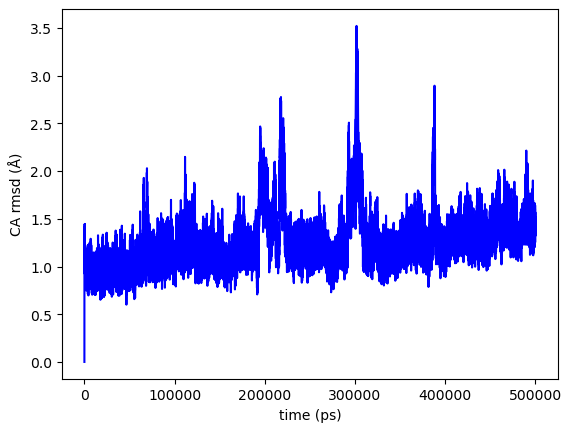

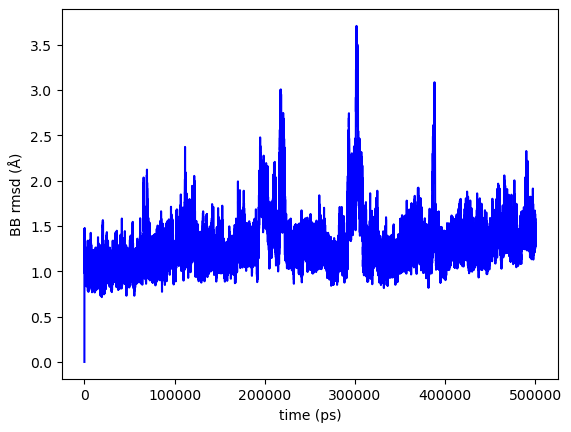

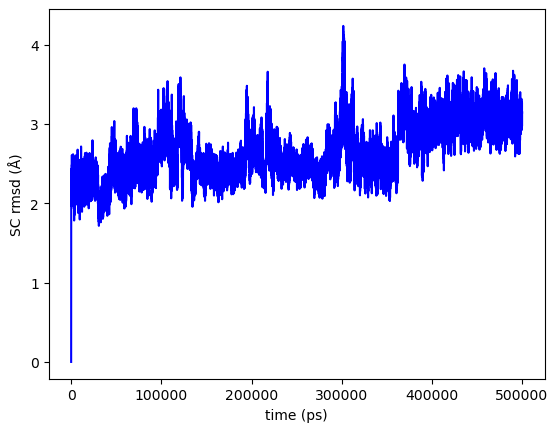

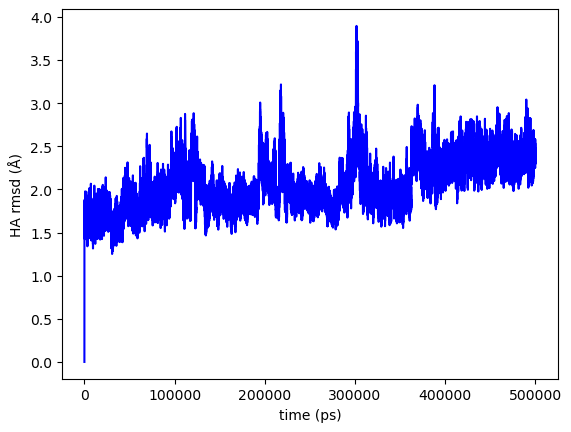

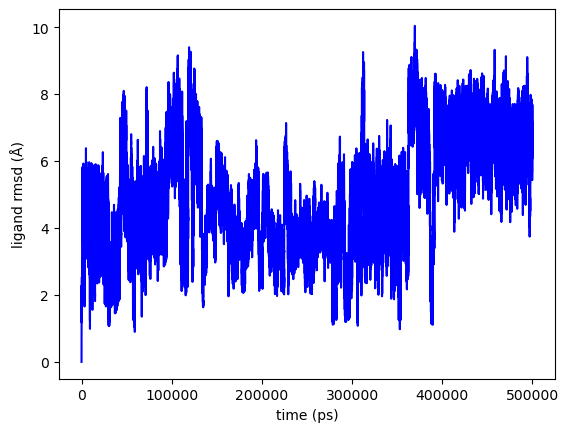

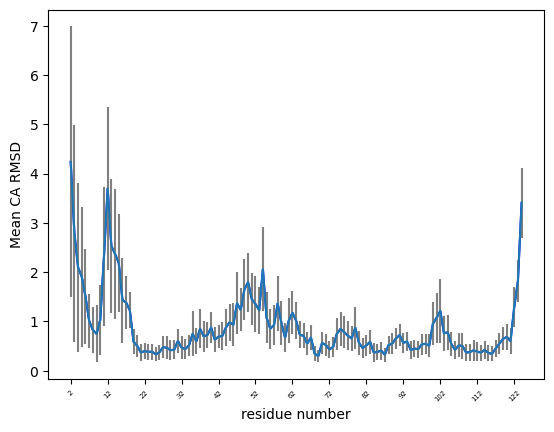

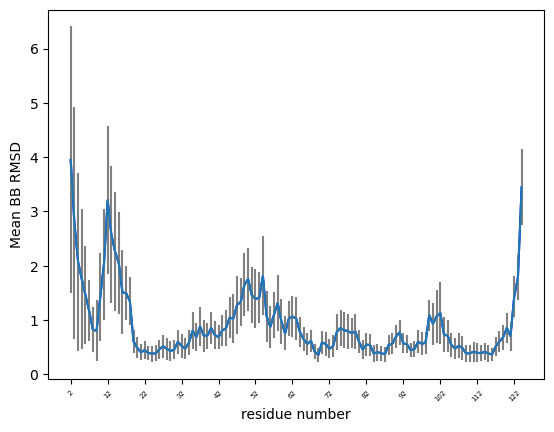

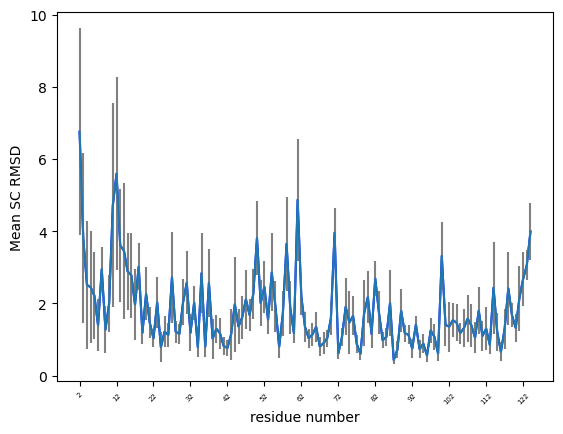

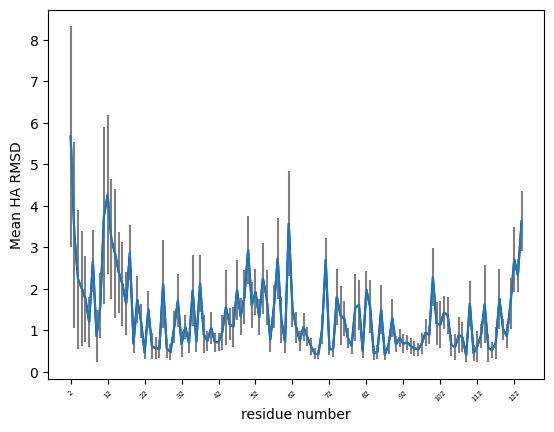

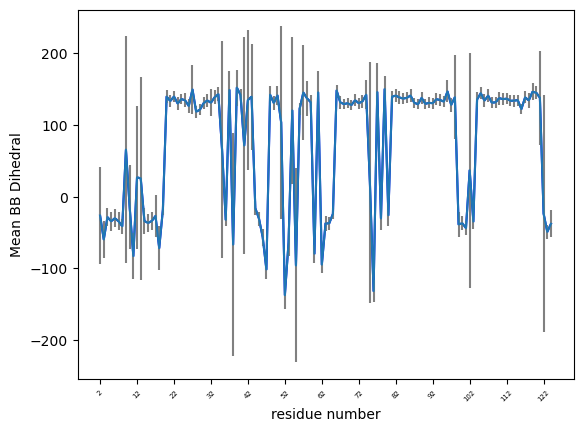

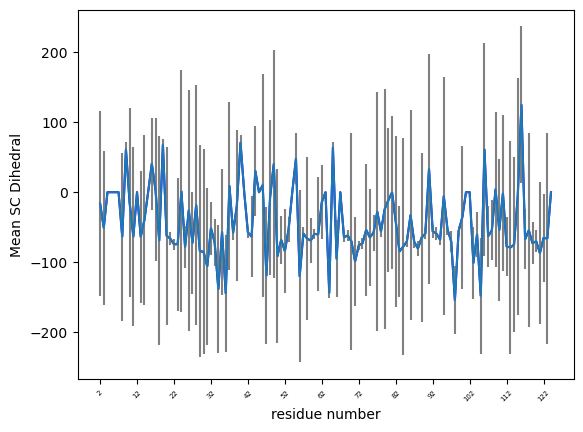

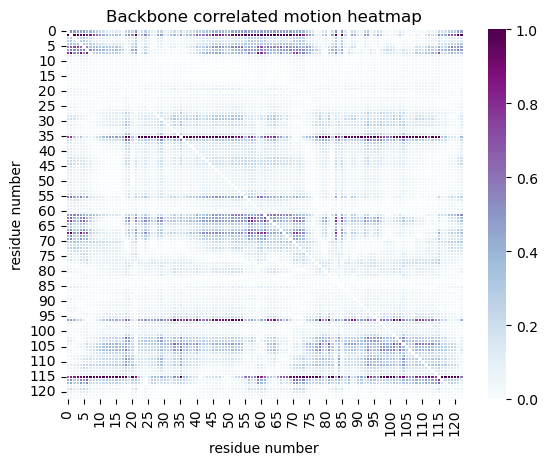

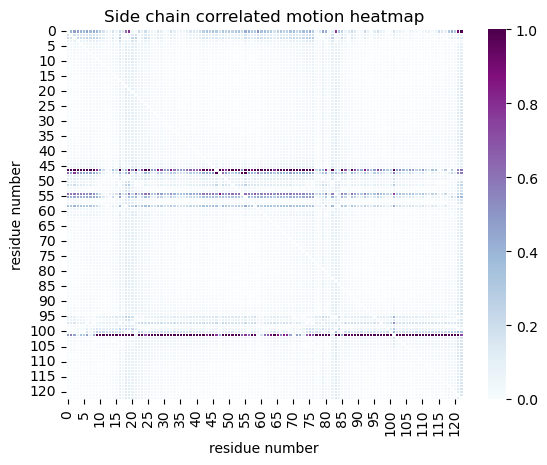

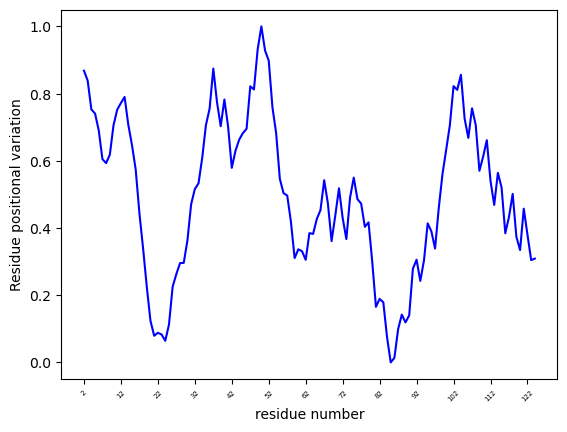

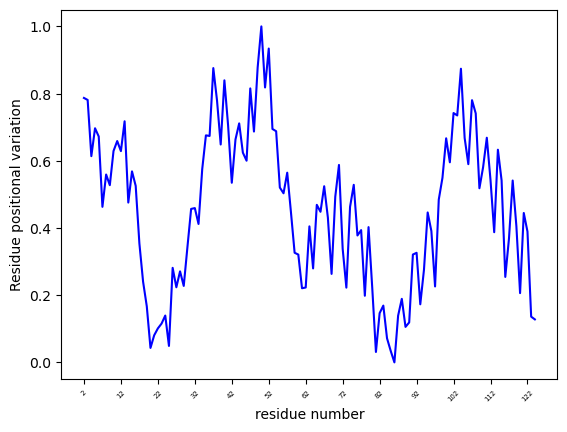

In [7]:
pA = proteinAnalysis(pdbfiles[1], out_dir, timestep=5)
pA.loadTrajectory(trajectories[1], topologies[2])
pA.plotProteinRMSD()
pA.plotLigandRMSD()
pA.plotByResRMSD()
pA.plotByResDih()
pA.correlatedMotions()

### Edits: 

~~add in the option to stride over trajectories, rather than run on the full... this will make troubleshooting easier too~~

~~normalize/scale the corrmatrix values to a better range~~

~~Change the color palette of the heatmap to be easier to read~~

~~Confirm that the ligand rmsd plot has only 1 line...~~

Maybe check that alignments are to non-loop residues for consistency

## Additional features to add:

### h-bond methods require user input, cannot function without

hydrogen bonding method (base)

hydrogen bonding method for ligand to protein, use the base

hydrogen bonding protein-protein residues, use the base function

354 print

  mprintf("size checks Esw_: %d, %d, %d\n", sizeof(Esw_), sizeof(Esw_[0]), sizeof(Esw_)/sizeof(Esw_[0]));
  mprintf("size checks Nsw_don_: %d, %d, %d\n", sizeof(Nsw_don_), sizeof(Nsw_don_[0]), sizeof(Nsw_don_)/sizeof(Nsw_don_[0]));
  mprintf("size checks Nsw_don: %d, %d, %d\n", sizeof(Nsw_don), sizeof(Nsw_don[0]), sizeof(Nsw_don)/sizeof(Nsw_don[0]));

asdfasdfas

